![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)

In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)
    
def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = shear)
  return augment(data, fun)
  
def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data
  
class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):  
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of? 
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True 
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)
  
class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels      
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry. 
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params, dropout = 1):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params, dropout = 1):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) 

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(dropout))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=1e-4, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])    
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16, 
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet', 
                                              include_top = False, 
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable
      
    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'], 
                  optimizer = optimizers.SGD(lr=1e-4, momentum=0.95), 
                  metrics=['accuracy'])

    return expert_model

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from imgaug import augmenters 

### defining project variables
# file variables
image_data_url       = 'https://drive.google.com/uc?id=1DNEiLAWguswhiLXGyVKsgHIRm1xZggt_'
metadata_url         = 'https://drive.google.com/uc?id=1MW3_FU6qc0qT_uG4bzxhtEHy4Jd6dCWb'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
gdown.download(image_data_url, './image_data.npy', True)
gdown.download(metadata_url, './metadata.csv', True)

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Milestone 1. Understanding and building Neural Networks

## Instructor-led Discussion: Steps for Building a NN in Keras

### What are neural networks?

Just as we went over last week, neural networks look something like this: 
![A 2 layer neural network](https://cdn-images-1.medium.com/max/1600/1*DW0Ccmj1hZ0OvSXi7Kz5MQ.jpeg)


Each orange and blue node is a neuron. The network itself is composed of a bunch of neurons that talk to each other and eventually give us a prediction. Let's get a bit more concrete with this...

To build neural networks in Python, we use the packages known as `tensorflow` and `keras`. Let's learn how to build and use these networks!

Tensorflow calls the various machine learning algorithms that it uses 'models'.  These 'models' are 'learning machines.''

1. We **teach** models by **training** them on **data**. 
2. We **use** models to **predict** things. 


Before we train the model or use it to predict something, we have to **create** the model. 

With the following code, we create a model that corresponds to our multineuron network for the housing problem above:

In [ ]:
# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

In [ ]:
# create our model by specifying and compiling it
model = Sequential()
model.add(Dense(4, input_shape=(3,),activation = 'relu'))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error'])

The things you'll want to pay most attention to as we go over how to build networks are: 
1. The number of neurons
2. The activation of the neurons
3. The losses and metrics

Everything else will work with the default settings!

Let's walk though what each of these lines of code means!

**1. Specify model**

```
model = Sequential()
```
In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it. 


**2. Add layers to the network**
```
model.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))
```
In this code, we `add` a `layer` of neurons to our network. 

This layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', which is when a neuron will only output positive numbers. 

```
model.add(Dense(1, activation = 'linear'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it** 

After having built the network, we want to train and use it, so we have to 'turn it on' and 'compile' it. To turn it on, we have to specify at the very least, a loss, an optimizer, and some ways of evaluating the model (metrics). Don't worry too much about what this means! Just know that this is necessary. 

```
model.compile(loss='mean_squared_error',
optimizer = 'adam',
metrics = ['mean_squared_error'])
  ```

Once we've created our network, we can use it very simply! Just like we did with sklearn, we define our input data (x), the true predictions from that data (y), and then train our model with `fit`. 

```
model.fit(x, y)
```


To use the model, you can use it to predict something with:
```
y = model.predict_classes(x)
```

You can actually use the model before you even train it! It just won't perform very well. 

## Exercise (Coding): A 2-Layer Model


We're going to build this model: 

![](http://cs231n.github.io/assets/nn1/neural_net.jpeg)

This network can be described as: 
* Input Layer: 3
* Layer 1 (Hidden): 4 neurons that are activated by `'relu'`
* Layer 2 (Output): 2 neurons that are activated by `'linear'`


We also want to compile the model with
`loss = 'binary_crossentropy'`

In [ ]:
# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

In [ ]:
# Fill in the blanks with your group!
### YOUR CODE HERE:
model_1 = Sequential()
model_1.add(Dense(4,input_shape = (3,), activation = 'relu'))
model_1.add(Dense(2, activation = 'softmax'))
model_1.compile(loss='binary_crossentropy',
                optimizer = 'adam', 
                metrics = ['accuracy'])
### END CODE

In [ ]:
#@title Run this to test if your model is right!
model_1_answer = Sequential()
model_1_answer.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1_answer.add(Dense(2, activation = 'softmax'))
model_1_answer.compile(loss='categorical_crossentropy',
optimizer = 'adam', 
metrics = ['accuracy'])

if model_to_string(model_1) == model_to_string(model_1_answer):
  print('Good job! Your model worked')
else: 
  print('Please check your code again!')

Good job! Your model worked


# Milestone 2. Exploring Neural Networks
## Instructor-led Discussion: Inputs and Outputs for our data


In our problem, we are given `images` of shape `(64,64,3)`, each assigned a label PNEUMONIA or HEALTHY. We want to identify the key things that we need to design our network. 

In your group, discuss: 

* What are our inputs?
* What is/are our outputs?

How could this look in a neural network diagram?

**Make a 3-layer (at least) neural network that works for this problem.**

**One of you will show the neural network to the group when you're done.**

## Activity 2a. Challenging pneumonia with our models

### Exercise (Coding) 

Today, we started with simple 'fully connected' neural networks that are perceptrons. There are other types of neural networks that we can use, however. 

We also want to try 'Convolutional Neural Networks'. Convolutional neural networks are networks that process images much like our visual system does -- by using this technique called 'convolutions'. We won't go too much into the details here or how it's implemented in tensorflow. If you'd like more details, you can try the optional activity out below!

Otherwise, we provide tensorflow/keras wrappers around both Multilayer Perceptrons and Convolutional Neural Networks
### Creating Models

To create our multilayer perceptrons with our wrapper:
```
dense = DenseClassifier(hidden_layer_sizes(2,2))
```
* hidden_layer_sizes: the number of neurons in each hidden layer
* epochs: the number of times that our network trains on the whole training manual


To create a convolution neural network:
```
cnn = CNNClassifier(num_hidden_layers = 3)
```
* num_hidden_layers: the number of hidden layers 

### Fitting and Scoring

There are default parameters to `.fit` you can call:

```
model.fit(train_data, train_labels, epochs = 100, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
```

The `shuffle` parameter is important for shuffling the training data before each epoch. The `monitor` callback is used to get a view on internal states and statistics of the model during training. Do not change these parameters!

To get your testing scores, use 

```
score = model.evaluate(train_data, train_labels, verbose=0)
```

Then `score[0]` will be test loss and `score[1]` will be test accuracy.

### Plotting

After fitting your model, you can plot the training and test accuracy over time with `plot_acc(model.history)`


**Question: What do you observe of the training and test accuracy over the training epochs?** 

Discuss this with your group and your instructor. 

In [ ]:
### YOUR CODE HERE
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()

dense = DenseClassifier(hidden_layer_sizes = (128,64))
dense.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
score = dense. evaluate(train_data, train_labels, verbose=0)

print('Test accuracy: %0.2f')
### END CODE

Train on 2000 samples, validate on 400 samples
Epoch 1/10
2000/2000 [==============================] - 0s 146us/step - loss: 0.6676 - accuracy: 0.5615 - val_loss: 0.6279 - val_accuracy: 0.6050
Epoch 2/10
1536/2000 [======================>.......] - ETA: 0s - loss: 0.5451 - accuracy: 0.7949

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


2000/2000 [==============================] - 0s 116us/step - loss: 0.5271 - accuracy: 0.8075 - val_loss: 0.5236 - val_accuracy: 0.8225
Epoch 3/10
2000/2000 [==============================] - 0s 109us/step - loss: 0.4187 - accuracy: 0.8730 - val_loss: 0.5155 - val_accuracy: 0.7075
Epoch 4/10
2000/2000 [==============================] - 0s 107us/step - loss: 0.3456 - accuracy: 0.8825 - val_loss: 0.4131 - val_accuracy: 0.8350
Epoch 5/10
2000/2000 [==============================] - 0s 106us/step - loss: 0.2924 - accuracy: 0.9055 - val_loss: 0.4251 - val_accuracy: 0.8000
Epoch 6/10
2000/2000 [==============================] - 0s 108us/step - loss: 0.2614 - accuracy: 0.9120 - val_loss: 0.5318 - val_accuracy: 0.7075
Epoch 7/10
2000/2000 [==============================] - 0s 107us/step - loss: 0.2464 - accuracy: 0.9130 - val_loss: 0.4060 - val_accuracy: 0.8025
Epoch 8/10
2000/2000 [==============================] - 0s 107us/step - loss: 0.2233 - accuracy: 0.9250 - val_loss: 0.3750 - val_accura

## Instructor-Led Discussion: Overfitting

**Questions:**
Was the best epoch necessarily the last epoch? 

You should check what the best epoch was at every step of the way!

**When does your model overfit?**


# Milestone 4. Expert models: Transfer learning


## Instructor-Led Discussion: Transfer Learning


For all of the machine leanring we've done thus far, we've used models that were built from 'scratch'. All of these models are like newborn babies that have neither seen nor explored the world. 

And, despite their cuteness, these babies require **a lot of education** to do much anything useful. 

Unfortunately, our training manual is pretty small to all the things in the big wide world. So, just training on our manual is going to be inherently limited. 


Luckily, there are **non-babies** (who we will refer to as experts) who have been out in the world for a long time! While these non-babies haven't seen our task, they have experience with a lot of other things. We can hand them our training manual and reasonably expect that they will pick up our task fairly quickly. 

In deep learning, the idea of using a model trained on another task as a starting point for your model is known as **transfer learning**. 

### VGG 16

For our transfer learning, we're going to use 'experts' built upon the famous 'ImageNet' classification problem. 

In ImageNet, participants were challenged to build machine learning models that could distinguish 14 million images' categories, where there were > 20,000 categories available. 

Below, we see examples of 4 different categories. 

![](http://cs231n.github.io/assets/trainset.jpg)



One of the experts we can use is VGG 16. VGG 16 was a network that was allowed to study the 14 million images 74 times. 

After its studying, VGG 16 was able to guess something close to the real label (top-5 accuracy) better than a human can.

![](https://cdn-images-1.medium.com/max/1600/0*V1muWIDnPVwZUuEv.png)

We're going to take an expert model like VGG16 and let it train on OUR x-rays. Hopefully, their experience with those 14 million images will help it understand pneumonia from our x-rays. 

### Exercise (Coding) | Within a student group

Let's tap an expert model to help us out with our pneumonia prediction!

We provide a wrapper that lets you 'call' up and employ expert models. You can call it like...

```
transfer = TransferClassifier(name = 'VGG16')
```

The experts we have on hand are:
* `VGG16`
* `VGG19`
* `ResNet50`
* `DenseNet121`



In [ ]:
### YOUR CODE HERE
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()

transfer = TransferClassifier(name = 'VGG16')

transfer.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

score = transfer.evaluate(train_data, train_labels, verbose=0)

print("the test loss = " + str(score[0]))
print ("the test accuracy = " + str(score[1]))

Train on 2000 samples, validate on 400 samples
Epoch 1/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6078 - accuracy: 0.6835 - val_loss: 0.4554 - val_accuracy: 0.8325
Epoch 2/10
 160/2000 [=>............................] - ETA: 1s - loss: 0.3971 - accuracy: 0.9000

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


2000/2000 [==============================] - 2s 1ms/step - loss: 0.2505 - accuracy: 0.9225 - val_loss: 1.0870 - val_accuracy: 0.5875
Epoch 3/10
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1439 - accuracy: 0.9520 - val_loss: 0.5990 - val_accuracy: 0.7925
Epoch 4/10
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1293 - accuracy: 0.9545 - val_loss: 0.5476 - val_accuracy: 0.7975
Epoch 5/10
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0878 - accuracy: 0.9705 - val_loss: 1.2276 - val_accuracy: 0.6300
Epoch 6/10
2000/2000 [==============================] - 2s 1ms/step - loss: 0.1269 - accuracy: 0.9515 - val_loss: 0.9037 - val_accuracy: 0.6575
Epoch 7/10
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0821 - accuracy: 0.9705 - val_loss: 0.5835 - val_accuracy: 0.8125
Epoch 8/10
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0871 - accuracy: 0.9725 - val_loss: 0.4594 - val_accuracy: 0.8350
Epo

# Milestone 5
## Instructor-led Discussion: Model Evaluation

## Activity 5a. How did we do on pneumonia prediction? 



### Exercise (Coding) 

Set your best model to the one you have trained (e.g., the transfer learning model).

In [ ]:
best_model = transfer ## Change this if another model did better!

As we learned last week, total accuracy does not reflect all that we want to know about a model's performance. It's just one metric out of many possible metrics for evaluating models. 

In the case of pneumonia prediction, we may be more interested in other quantities, such as 'how accurate were we on the pneumonia category?' or 'how accurate were we on the normal category?' or 'how much of pneumonia were confused for normal?' or vice versa. 



Our metrics for classification can be described in terms of a 'confusion matrix', shown below. 

![Confusion Matrix](https://cdn-images-1.medium.com/max/1600/1*Z54JgbS4DUwWSknhDCvNTQ.png)

In a confusion matrix, we think in terms of 'actual' and 'predicted values'. If we take Pneumonia = 1/Positive and Normal = 0/Negative, then...

* True positive: True pneumonia: Pneumonia predicted as pneumonia
* True negative: True normal: Normal predicted as normal
* False positive: False pneumonia: Normal mistaken as pneumonia
* False negative: False normal: Pneumonia mistaken as normal


The `sklearn` package makes calculating confusion matrices very quick! Its `metrics` submodule actually comes with a `confusion_matrix` tool. Let's start by grabbing that.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

To use `confusion_matrix`, we need:
* `labels`: the labels of the data (1 - PNEUMONIA or 0 - NORMAL)
* `predictions`: what our model thinks the labels are

To get `predictions`, we have to give our model `test_labels`, our `test_data`, and ask it to give us `predictions`. We'll do that with 

```


In [ ]:
predictions = best_model.predict_classes(test_data)

First, use `accuracy_score` to get our accuracy

In [ ]:
print('Accuracy is %d %%'%(accuracy_score(test_labels, predictions)*100.0))

Accuracy is 50 %


Now let's get our confusion matrix, and split it out into true positive, true negative, false positive, and false negative!

In [ ]:
confusion = confusion_matrix(test_labels, predictions)
print(confusion)

[[  0 200]
 [  0 200]]


In [ ]:
tp  = confusion[1][1]
tn  = confusion[0][0] 
fp = confusion[0][1]
fn = confusion[1][0]

In [ ]:
print('True positive: %d'%tp)
print('True negative: %d'%tn)
print('False positive: %d'%fp)
print('False negative: %d'%fn)

True positive: 200
True negative: 0
False positive: 200
False negative: 0


We can visualize the confusion matrix with seaborn to make it easier for our eyes...

In [ ]:
# grab our plotting package
import seaborn as sns
import matplotlib.pyplot as plt

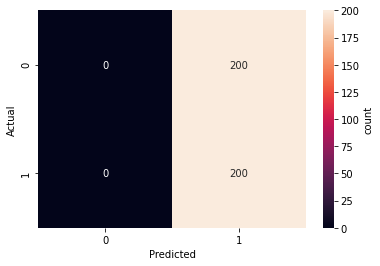

In [ ]:
sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});
plt.ylabel('Actual');
plt.xlabel('Predicted');

## Instructor-Led Discussion: Comparing False Postives and False Negatives

**Now that we have our confusion matrix, let's take a step back and discuss**

What did our model confuse more? 
* PNEUMONIA for NORMAL or...
* NORMAL for PNEUMONIA

Why do you think it might have confused one for the other? 

**Discuss with your instructor what you got and also...**

What is more problematic? False positives or False negatives? 

Which of these metrics do we want to keep low? 


# Fin!


To recap, we built neural network models to see if we can do better than our simple logistic regression. It turns out that we can! And, also, by introducing convolutions to our networks (making the convolutional neural networks), we can improve by quite a lot. Finally, we employed pretrained 'expert' models to boost our performance even further.

In the next section, we'll test out our models on actual field data!

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)